In [9]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from statistics import mean, stdev

In [4]:
URLdataOG = pd.read_csv(r"C:\Users\Aden\Desktop\Phishing URL RF\URL Phishing\PhiUSIIL_Phishing_URL_Dataset.csv")


URLdataOG.head()
URLdata = URLdataOG.copy()

In [5]:
# Select pre-load features
pre_load_features = [
    'URLLength',
    'DomainLength',
    'NoOfDegitsInURL',
    'NoOfLettersInURL',
    'NoOfSubDomain',
    'TLDLength',
    'NoOfEqualsInURL',
    'NoOfQMarkInURL',
    'NoOfAmpersandInURL'        
]

In [6]:

X = URLdata[pre_load_features]
y = URLdata['label']

# Define partition ratios
partition_ratios = [
    (0.2, 0.8),  # 20/80
    (0.5, 0.5),  # 50/50
    (0.8, 0.2)   # 80/20
]

# Define hyperparameter search space
param_grid = {
    'n_neighbors': list(range(1, 31, 2))  # Testing odd numbers from 1 to 30
}

In [7]:
def run_trial(X, y, train_size, random_state):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=random_state)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    
    # Find best k using GridSearchCV
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(
        knn,
        param_grid,
        cv=kf,
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train_scaled, y_train)
    
    # Get best model
    best_knn = grid_search.best_estimator_
    
    # Get scores
    train_score = best_knn.score(X_train_scaled, y_train)
    test_score = best_knn.score(X_test_scaled, y_test)
    val_scores = cross_val_score(best_knn, X_train_scaled, y_train, cv=kf)
    
    return {
        'train_score': train_score,
        'validation_score': mean(val_scores),
        'test_score': test_score,
        'best_params': grid_search.best_params_
    }

In [10]:
# Run experiments for each partition ratio
results = {}
for train_size, test_size in partition_ratios:
    ratio_results = []
    print(f"\nRunning experiments for {train_size*100:.0f}/{test_size*100:.0f} split")
    
    for trial in range(3):
        print(f"Trial {trial + 1}/3...")
        trial_results = run_trial(X, y, train_size, random_state=42+trial)
        ratio_results.append(trial_results)
    
    # Calculate averages
    avg_results = {
        'avg_train_score': mean([r['train_score'] for r in ratio_results]),
        'avg_validation_score': mean([r['validation_score'] for r in ratio_results]),
        'avg_test_score': mean([r['test_score'] for r in ratio_results]),
        'std_train_score': stdev([r['train_score'] for r in ratio_results]),
        'std_validation_score': stdev([r['validation_score'] for r in ratio_results]),
        'std_test_score': stdev([r['test_score'] for r in ratio_results]),
        'individual_trials': ratio_results
    }
    
    results[f"{train_size*100:.0f}/{test_size*100:.0f}"] = avg_results

# Print results
for split, res in results.items():
    print(f"\nResults for {split} split:")
    print(f"Average Training Score: {res['avg_train_score']:.4f} ± {res['std_train_score']:.4f}")
    print(f"Average Validation Score: {res['avg_validation_score']:.4f} ± {res['std_validation_score']:.4f}")
    print(f"Average Test Score: {res['avg_test_score']:.4f} ± {res['std_test_score']:.4f}")
    
    # Print best parameters for each trial
    print("\nBest parameters for each trial:")
    for i, trial in enumerate(res['individual_trials']):
        print(f"Trial {i+1}: {trial['best_params']}")


Running experiments for 20/80 split
Trial 1/3...
Trial 2/3...
Trial 3/3...

Running experiments for 50/50 split
Trial 1/3...
Trial 2/3...
Trial 3/3...

Running experiments for 80/20 split
Trial 1/3...
Trial 2/3...
Trial 3/3...

Results for 20/80 split:
Average Training Score: 0.9904 ± 0.0016
Average Validation Score: 0.9813 ± 0.0016
Average Test Score: 0.9822 ± 0.0003

Best parameters for each trial:
Trial 1: {'n_neighbors': 3}
Trial 2: {'n_neighbors': 1}
Trial 3: {'n_neighbors': 1}

Results for 50/50 split:
Average Training Score: 0.9903 ± 0.0007
Average Validation Score: 0.9852 ± 0.0008
Average Test Score: 0.9872 ± 0.0006

Best parameters for each trial:
Trial 1: {'n_neighbors': 3}
Trial 2: {'n_neighbors': 3}
Trial 3: {'n_neighbors': 3}

Results for 80/20 split:
Average Training Score: 0.9914 ± 0.0001
Average Validation Score: 0.9880 ± 0.0002
Average Test Score: 0.9891 ± 0.0007

Best parameters for each trial:
Trial 1: {'n_neighbors': 3}
Trial 2: {'n_neighbors': 3}
Trial 3: {'n_neig

In [13]:
# Evaluate the model
accuracy_simple = accuracy_score(y_test_simple, y_pred_simple)
print("\nSimplified Model Results:")
print(f"Accuracy: {accuracy_simple:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_simple, y_pred_simple))


Simplified Model Results:
Accuracy: 0.8095

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.71      0.76     20124
           1       0.80      0.88      0.84     27035

    accuracy                           0.81     47159
   macro avg       0.81      0.80      0.80     47159
weighted avg       0.81      0.81      0.81     47159



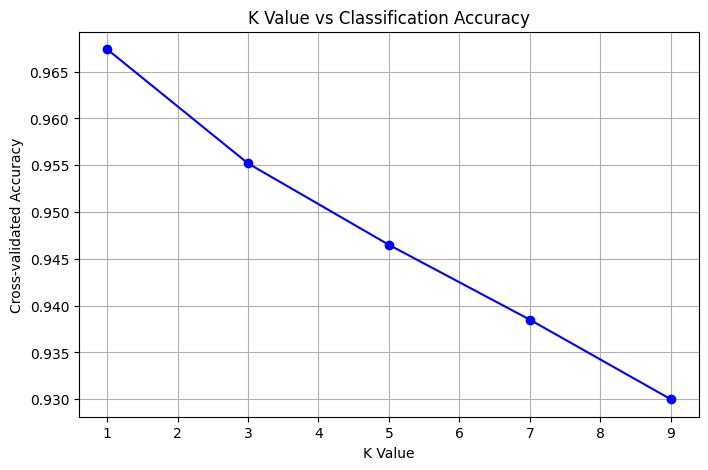

In [20]:
sample_size = 10000  
indices = np.random.choice(len(X_simple), sample_size, replace=False)
X_simple_sample = X_simple.iloc[indices]
y_sample = y.iloc[indices]

# Test K values from 1 to 10
k_values = [i for i in range(1, 11, 2)]  # Test odd numbers: 1,3,5,7,9
scores = []

scaler = StandardScaler()
X_simple_scaled = scaler.fit_transform(X_simple_sample)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_simple_scaled, y_sample, cv=3)
    scores.append(np.mean(score))

plt.figure(figsize=(8,5))
plt.plot(k_values, scores, 'b-', marker='o')
plt.xlabel('K Value')
plt.ylabel('Cross-validated Accuracy')
plt.title('K Value vs Classification Accuracy')
plt.grid(True)
plt.show()

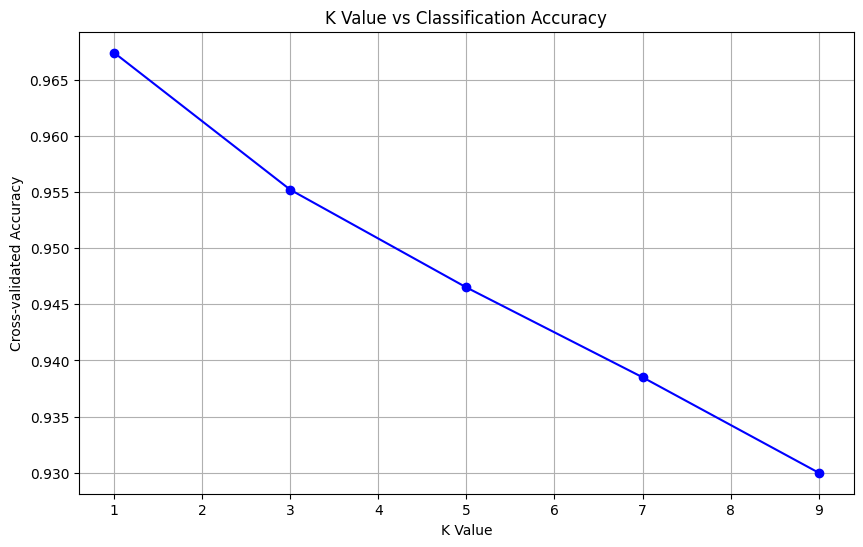

In [21]:

# Visualize the results
plt.figure(figsize=(10,6))
plt.plot(k_values, scores, 'b-', marker='o')
plt.xlabel('K Value')
plt.ylabel('Cross-validated Accuracy')
plt.title('K Value vs Classification Accuracy')
plt.grid(True)
plt.show()

In [22]:
# First method (single train-test split)
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    X_simple_noisy, y, test_size=0.2, random_state=42
)

scaler_simple = StandardScaler()
X_train_simple_scaled = scaler_simple.fit_transform(X_train_simple)
X_test_simple_scaled = scaler_simple.transform(X_test_simple)

knn_simple = KNeighborsClassifier(n_neighbors=3)
knn_simple.fit(X_train_simple_scaled, y_train_simple)
y_pred_simple = knn_simple.predict(X_test_simple_scaled)

# Print single split accuracy
print("\nSingle Split Results:")
print(f"Accuracy: {accuracy_score(y_test_simple, y_pred_simple):.4f}")

# Second method (cross-validation on same data)
X_scaled = scaler_simple.fit_transform(X_simple_noisy)
cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), 
                          X_scaled, y, cv=5)
print("\nCross-validation Results:")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Std Accuracy: {cv_scores.std():.4f}")


Single Split Results:
Accuracy: 0.8095

Cross-validation Results:
Mean Accuracy: 0.8080
Std Accuracy: 0.0127


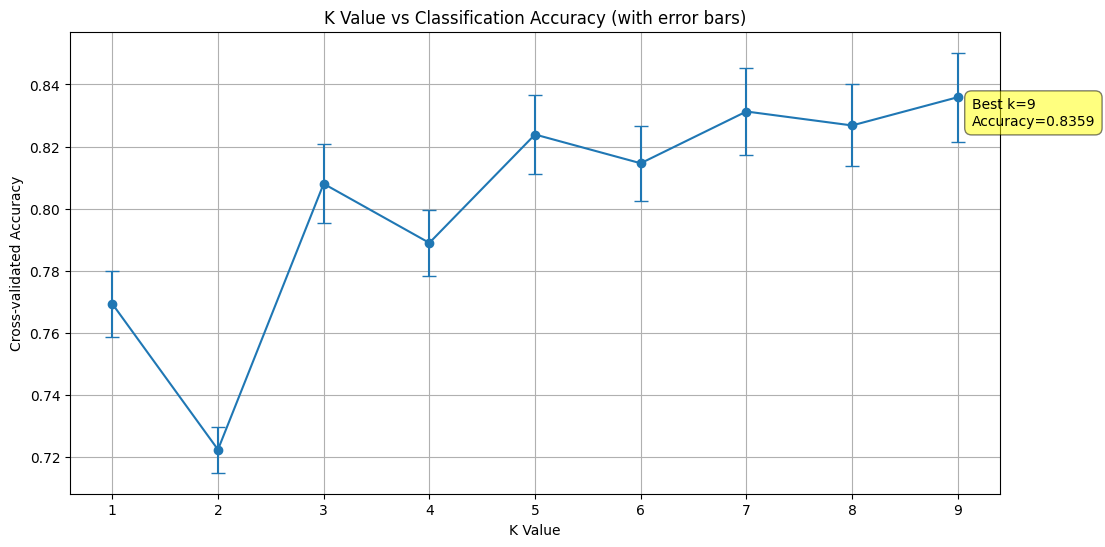


Best k value: 9
Best accuracy: 0.8359

Detailed scores for each k:
k=1: 0.7693 (+/- 0.0211)
k=2: 0.7224 (+/- 0.0149)
k=3: 0.8080 (+/- 0.0254)
k=4: 0.7890 (+/- 0.0215)
k=5: 0.8239 (+/- 0.0256)
k=6: 0.8146 (+/- 0.0241)
k=7: 0.8313 (+/- 0.0280)
k=8: 0.8268 (+/- 0.0264)
k=9: 0.8359 (+/- 0.0287)


In [25]:

k_values = [i for i in range(1, 10)]  # Test odd values from 1 to 19
scores = []
std_scores = []

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_simple_noisy)

# Test each k value
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X_scaled, y, cv=5)
    scores.append(np.mean(cv_scores))
    std_scores.append(np.std(cv_scores))

# Find the best k value
best_k = k_values[np.argmax(scores)]
best_score = max(scores)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.errorbar(k_values, scores, yerr=std_scores, fmt='o-', capsize=5)
plt.xlabel('K Value')
plt.ylabel('Cross-validated Accuracy')
plt.title('K Value vs Classification Accuracy (with error bars)')
plt.grid(True)

# Add best k value annotation
plt.annotate(f'Best k={best_k}\nAccuracy={best_score:.4f}', 
            xy=(best_k, best_score), 
            xytext=(10, -20),
            textcoords='offset points',
            ha='left',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

plt.show()

print(f"\nBest k value: {best_k}")
print(f"Best accuracy: {best_score:.4f}")

print("\nDetailed scores for each k:")
for k, score, std in zip(k_values, scores, std_scores):
    print(f"k={k}: {score:.4f} (+/- {std*2:.4f})")

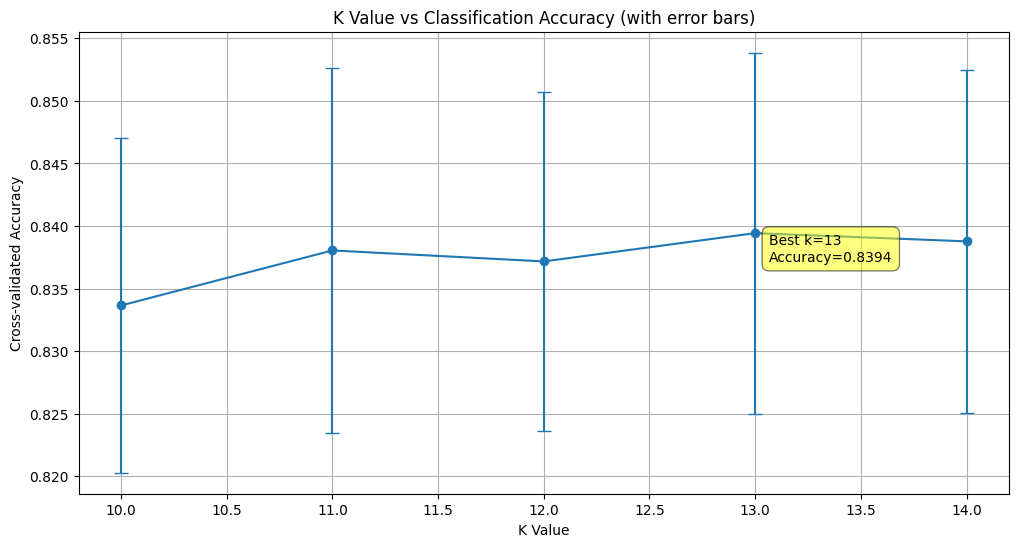


Best k value: 13
Best accuracy: 0.8394

Detailed scores for each k:
k=10: 0.8337 (+/- 0.0267)
k=11: 0.8381 (+/- 0.0291)
k=12: 0.8372 (+/- 0.0271)
k=13: 0.8394 (+/- 0.0288)
k=14: 0.8388 (+/- 0.0275)


In [26]:
k_values = [i for i in range(10, 15)]  # Test odd values from 1 to 19
scores = []
std_scores = []

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_simple_noisy)

# Test each k value
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X_scaled, y, cv=5)
    scores.append(np.mean(cv_scores))
    std_scores.append(np.std(cv_scores))

# Find the best k value
best_k = k_values[np.argmax(scores)]
best_score = max(scores)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.errorbar(k_values, scores, yerr=std_scores, fmt='o-', capsize=5)
plt.xlabel('K Value')
plt.ylabel('Cross-validated Accuracy')
plt.title('K Value vs Classification Accuracy (with error bars)')
plt.grid(True)

# Add best k value annotation
plt.annotate(f'Best k={best_k}\nAccuracy={best_score:.4f}', 
            xy=(best_k, best_score), 
            xytext=(10, -20),
            textcoords='offset points',
            ha='left',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

plt.show()

print(f"\nBest k value: {best_k}")
print(f"Best accuracy: {best_score:.4f}")

# Optional: Print detailed scores for each k
print("\nDetailed scores for each k:")
for k, score, std in zip(k_values, scores, std_scores):
    print(f"k={k}: {score:.4f} (+/- {std*2:.4f})")

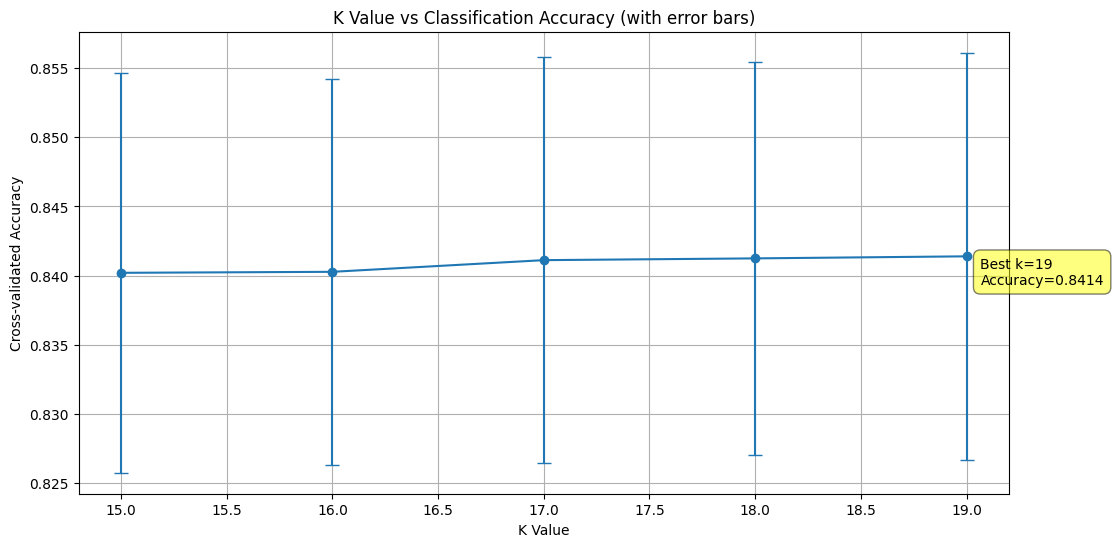


Best k value: 19
Best accuracy: 0.8414

Detailed scores for each k:
k=15: 0.8402 (+/- 0.0289)
k=16: 0.8403 (+/- 0.0279)
k=17: 0.8411 (+/- 0.0294)
k=18: 0.8412 (+/- 0.0284)
k=19: 0.8414 (+/- 0.0294)


In [27]:
k_values = [i for i in range(15, 20)]  # Test odd values from 1 to 19
scores = []
std_scores = []

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_simple_noisy)

# Test each k value
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X_scaled, y, cv=5)
    scores.append(np.mean(cv_scores))
    std_scores.append(np.std(cv_scores))

# Find the best k value
best_k = k_values[np.argmax(scores)]
best_score = max(scores)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.errorbar(k_values, scores, yerr=std_scores, fmt='o-', capsize=5)
plt.xlabel('K Value')
plt.ylabel('Cross-validated Accuracy')
plt.title('K Value vs Classification Accuracy (with error bars)')
plt.grid(True)

# Add best k value annotation
plt.annotate(f'Best k={best_k}\nAccuracy={best_score:.4f}', 
            xy=(best_k, best_score), 
            xytext=(10, -20),
            textcoords='offset points',
            ha='left',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

plt.show()

print(f"\nBest k value: {best_k}")
print(f"Best accuracy: {best_score:.4f}")

print("\nDetailed scores for each k:")
for k, score, std in zip(k_values, scores, std_scores):
    print(f"k={k}: {score:.4f} (+/- {std*2:.4f})")

In [28]:
# Train KNN model
knn_simple = KNeighborsClassifier(n_neighbors=13)
knn_simple.fit(X_train_simple_scaled, y_train_simple)

KNeighborsClassifier(n_neighbors=13)

In [29]:
# Make predictions
y_pred_simple = knn_simple.predict(X_test_simple_scaled)

In [30]:
# Evaluate the model
accuracy_simple = accuracy_score(y_test_simple, y_pred_simple)
print("\nSimplified Model Results:")
print(f"Accuracy: {accuracy_simple:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_simple, y_pred_simple))


Simplified Model Results:
Accuracy: 0.8428

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.69      0.79     20124
           1       0.81      0.96      0.87     27035

    accuracy                           0.84     47159
   macro avg       0.86      0.82      0.83     47159
weighted avg       0.86      0.84      0.84     47159

